In [1]:
#CT image reconstruct through the FBP algorithm
#Written by Ren-Qi Pan
import math
import os
from pydicom import dcmread, dcmwrite
import pydicom
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import numpy as np
import cv2

In [2]:
_pth = r"E:\CMC\pyprojects\radio_therapy\dose-3d\dataset\VMAT 2025 - 1. CENTRAL TARGET\TRIAL 1\873251666"

In [3]:
_files = os.listdir(_pth)

In [4]:
dcm = dcmread(os.path.join(_pth, _files[0]))
shape = dcm.Rows, dcm.Columns

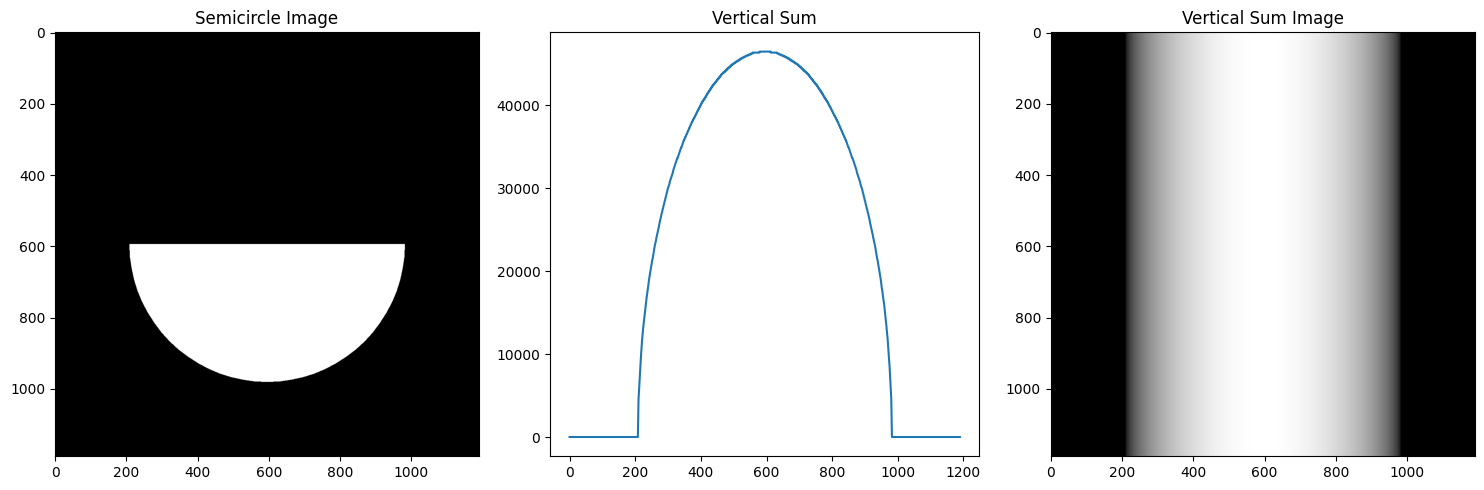

Normalized image shape: (1190, 1190)
Normalized image min: 0.0
Normalized image max: 0.99999994
Normalized image mean: 0.50971514


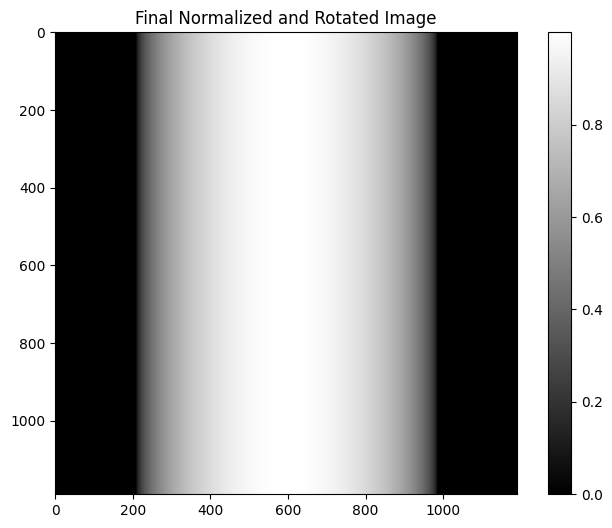

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define image size and pixel spacing
pixel_spacing = 0.336  # mm/pixel
image_size = 1190  # Image is 1190x1190 pixels
radius_cm = 13  # Radius in cm
radius_pixels = int((radius_cm * 10) / pixel_spacing)  # Convert cm to mm and divide by spacing

# Create empty image
image = np.zeros((image_size, image_size), dtype=np.uint8)

# Define center of semicircle
center = (image_size // 2, image_size // 2)

# Draw filled semicircle (top half)
cv2.ellipse(image, center, (radius_pixels, radius_pixels),
            angle=0, startAngle=0, endAngle=180, color=120, thickness=-1)

# Compute vertical sum
vertical_sum = np.sum(image, axis=0)

# Create vertical sum image by repeating values across rows
vertical_image = np.tile(vertical_sum, (image_size, 1)).astype(np.uint16)

# Plot original images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Semicircle Image')
axs[1].plot(vertical_sum)
axs[1].set_title('Vertical Sum')
axs[2].imshow(vertical_image, cmap='gray')
axs[2].set_title('Vertical Sum Image')
plt.tight_layout()
plt.show()

# Normalize to 0–1 and convert to float32
normalized_image = cv2.normalize(vertical_image.astype(np.float32), None, alpha=0.0, beta=1.0,
                                 norm_type=cv2.NORM_MINMAX)

# Fix: Use correct rotation flag for 90 degrees clockwise
# normalized_image = cv2.rotate(normalized_image, cv2.ROTATE_90_CLOCKWISE)

# Alternative fixes (choose one):
# For 90 degrees counterclockwise: cv2.ROTATE_90_COUNTERCLOCKWISE  
# For 180 degrees: cv2.ROTATE_180

# Verify the result
print("Normalized image shape:", normalized_image.shape)
print("Normalized image min:", np.min(normalized_image))
print("Normalized image max:", np.max(normalized_image))
print("Normalized image mean:", np.mean(normalized_image))

# Display the final normalized and rotated image
plt.figure(figsize=(8, 6))
plt.imshow(normalized_image, cmap='gray')
plt.title('Final Normalized and Rotated Image')
plt.colorbar()
plt.show()

In [6]:
# Create ramp filters - 1190x1190 normalized
image_size = 1190

# Create coordinate arrays
x = np.linspace(0, 1, image_size)
y = np.linspace(0, 1, image_size)

# Create 2D coordinate grids
X, Y = np.meshgrid(x, y)

# Generate all four ramp combinations
left_to_right = X  # 0 to 1 from left to right
right_to_left = 1 - X  # 1 to 0 from left to right (0 to 1 from right to left)
top_to_bottom = Y  # 0 to 1 from top to bottom
bottom_to_top = 1 - Y  # 1 to 0 from top to bottom (0 to 1 from bottom to top)


In [7]:
pixel_spacing = 0.336  # mm/pixel
ramp_length_cm = 27    # cm
image_size = 1190      # pixels

# Convert ramp length to pixels
ramp_length_mm = ramp_length_cm * 10  # Convert cm to mm
ramp_length_pixels = int(ramp_length_mm / pixel_spacing)

print(f"Ramp length: {ramp_length_cm} cm = {ramp_length_mm} mm = {ramp_length_pixels} pixels")
print(f"Image size: {image_size} pixels")

# Create base coordinate arrays for full image
x_full = np.arange(image_size)
y_full = np.arange(image_size)
X_full, Y_full = np.meshgrid(x_full, y_full)

# Calculate center position
center_x = image_size // 2
center_y = image_size // 2

# Initialize ramp arrays (all zeros initially)
ramp_lr = np.zeros((image_size, image_size))  # Left to Right
ramp_rl = np.zeros((image_size, image_size))  # Right to Left
ramp_tb = np.zeros((image_size, image_size))  # Top to Bottom
ramp_bt = np.zeros((image_size, image_size))  # Bottom to Top

# Create ramps only within the specified length
half_ramp = ramp_length_pixels // 2

# Left to Right ramp (centered)
start_x = max(0, center_x - half_ramp)
end_x = min(image_size, center_x + half_ramp)
ramp_width = end_x - start_x
if ramp_width > 0:
    ramp_lr[:, start_x:end_x] = np.linspace(0, 1, ramp_width)

# Right to Left ramp (centered)
ramp_rl[:, start_x:end_x] = np.linspace(1, 0, ramp_width)

Ramp length: 27 cm = 270 mm = 803 pixels
Image size: 1190 pixels


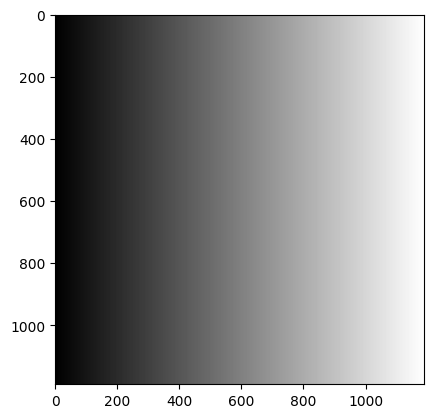

In [8]:
plt.imshow(left_to_right, cmap='gray')

In [ ]:
g_angle = []
_images = np.zeros((len(_files),shape[0], shape[0]), dtype=np.uint16)
prev = np.zeros((shape[0], shape[0]), dtype=np.int64)
curr = np.zeros((shape[0], shape[0]), dtype=np.int64)
_center_pixel = []
_raw_datas = []


# translate
import cv2

scaling = 0.336
tx = int(0 * scaling) # For shifting right; use -20 for shifting left
ty = int(0 * scaling)  # No vertical shift

tx2 = int(-100 * scaling) # For shifting right; use -20 for shifting left
ty2 = int(0 * scaling)  # No vertical shift

print(f"tx: {tx}, ty: {ty}")

M = np.float32([[1, 0, tx], [0, 1, ty]])
M2 = np.float32([[1, 0, tx2], [0, 1, ty2]])
rows, cols = dcm.Rows, dcm.Columns


_skip_images = 0
for idx, _f in enumerate(tqdm(np.sort(_files))):
    _fname = os.path.join(_pth, _f)
    raw = dcmread(_fname)
    curr = raw.pixel_array
    
    curr = cv2.warpAffine(curr, M, (cols, rows))
    
    # normalized image transformation
    norm_image = cv2.warpAffine(normalized_image, M2, (cols, rows))
    
    _m = curr - prev
    _center_pixel.append(_m[595,595])
    if np.max(abs(_m)) > 10000:
        # _images[idx, :, :] = _images[idx-1, :, :]
        # g_angle.append(g_angle[idx-1])
        
        # _images[idx, :, :] = -np.abs(curr - prev)
        # g_angle.append(raw.GantryAngle)
        
        
        _m = -np.abs(curr - prev)
        g_angle.append(raw.GantryAngle)
        
        print(idx)
        # _skip_images += 1
        pass
    else:
        _im = curr - prev
        
        # _im = _im+np.multiply(_im, norm_image)
        # _im = np.multiply(_im, norm_image)
        _im = np.multiply(_im, ramp_lr)
        _im = np.multiply(_im, ramp_rl)
        # _im = _im
        _images[idx, :, :] = _im*4
        
        # multiply with the normalized image
        
        
        
        # prev = curr
        g_angle.append(raw.GantryAngle)
    # if idx == 120:
    #     break
    prev = curr


tx: 0, ty: 0


  0%|          | 0/432 [00:00<?, ?it/s]

 18%|█▊        | 77/432 [00:01<00:07, 47.31it/s]

68


 37%|███▋      | 159/432 [00:03<00:05, 47.16it/s]

149


 74%|███████▎  | 318/432 [00:06<00:02, 50.88it/s]

309


100%|██████████| 432/432 [00:09<00:00, 46.88it/s]


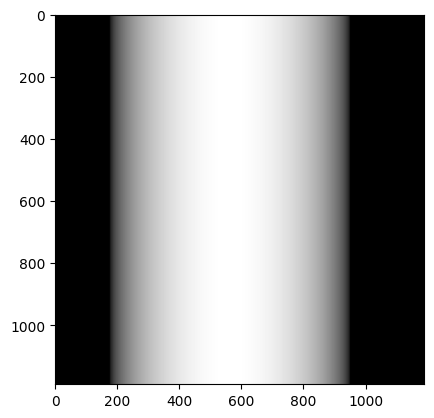

In [10]:
plt.imshow(norm_image, cmap='gray')

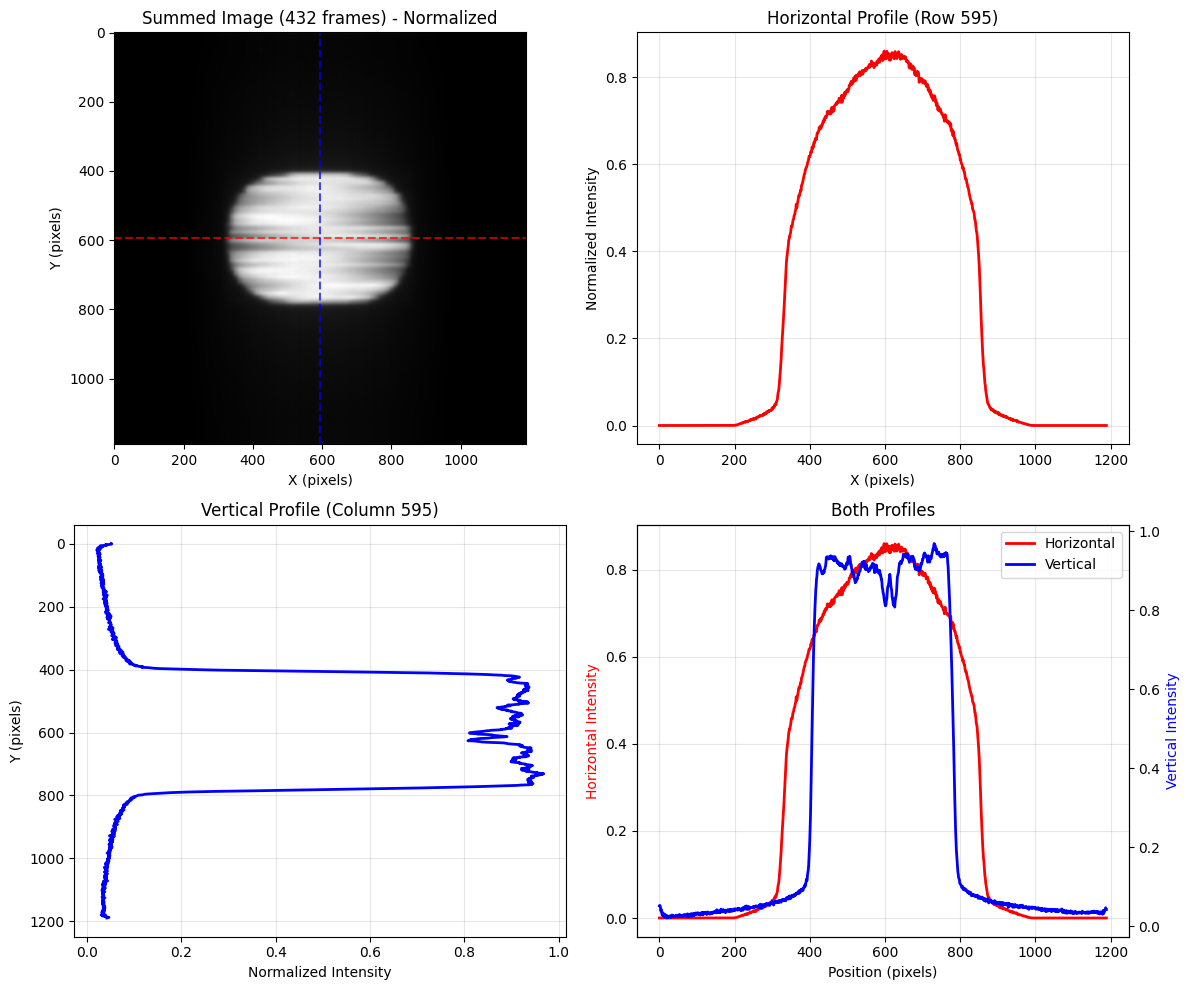

Original shape: (432, 1190, 1190)
Summed image range: 0.00 to 107854.00
Normalized range: 0.000 to 1.000
Center coordinates: (595, 595)


In [11]:
# Sum all images along the first axis (F dimension)
summed_image = np.sum(_images, axis=0)

# Normalize the summed image to 0-1 range
normalized_summed = (summed_image - np.min(summed_image)) / (np.max(summed_image) - np.min(summed_image))

# Get image dimensions
height, width = normalized_summed.shape

# Calculate center coordinates
center_row = height // 2
center_col = width // 2

# Extract profiles at center
horizontal_profile = normalized_summed[center_row, :]  # Row at center
vertical_profile = normalized_summed[:, center_col]    # Column at center

# Plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Summed and normalized image with center lines
ax1.imshow(normalized_summed, cmap='gray')
ax1.axhline(y=center_row, color='red', linestyle='--', alpha=0.7)
ax1.axvline(x=center_col, color='blue', linestyle='--', alpha=0.7)
ax1.set_title(f'Summed Image ({_images.shape[0]} frames) - Normalized')
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')

# Horizontal profile
ax2.plot(horizontal_profile, 'r-', linewidth=2)
ax2.set_title(f'Horizontal Profile (Row {center_row})')
ax2.set_xlabel('X (pixels)')
ax2.set_ylabel('Normalized Intensity')
ax2.grid(True, alpha=0.3)

# Vertical profile
ax3.plot(vertical_profile, np.arange(height), 'b-', linewidth=2)
ax3.set_title(f'Vertical Profile (Column {center_col})')
ax3.set_xlabel('Normalized Intensity')
ax3.set_ylabel('Y (pixels)')
ax3.grid(True, alpha=0.3)
ax3.invert_yaxis()

# Both profiles together
ax4_twin = ax4.twinx()
ax4.plot(horizontal_profile, 'r-', linewidth=2, label='Horizontal')
ax4_twin.plot(vertical_profile, 'b-', linewidth=2, label='Vertical')
ax4.set_title('Both Profiles')
ax4.set_xlabel('Position (pixels)')
ax4.set_ylabel('Horizontal Intensity', color='red')
ax4_twin.set_ylabel('Vertical Intensity', color='blue')
ax4.grid(True, alpha=0.3)

# Add legends
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_twin.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

# Print some info
print(f"Original shape: {_images.shape}")
print(f"Summed image range: {np.min(summed_image):.2f} to {np.max(summed_image):.2f}")
print(f"Normalized range: {np.min(normalized_summed):.3f} to {np.max(normalized_summed):.3f}")
print(f"Center coordinates: ({center_col}, {center_row})")

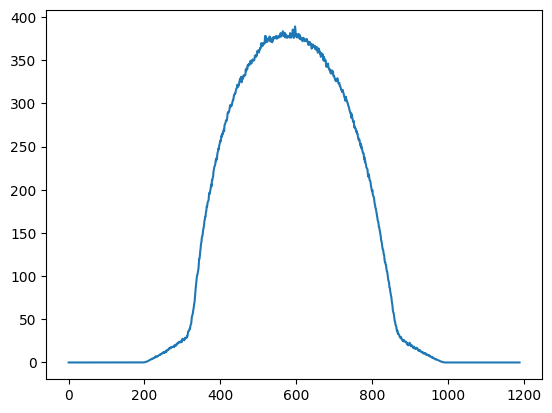

In [12]:
plt.plot(np.sum(normalized_summed, axis=0))

In [13]:
# asdf

In [14]:
g_angle = np.array(g_angle)
sorted_inx = np.argsort(g_angle)

sorted_images = np.zeros((len(_files) -_skip_images,shape[0], shape[0]), dtype=np.uint16)
_center_pixel_skipped = []


for idx, val in enumerate(tqdm(sorted_inx)):
    sorted_images[idx, :, :] = _images[val, :, :]
    _center_pixel_skipped.append(_images[val, 595, 595])

100%|██████████| 429/429 [00:00<00:00, 1271.43it/s]


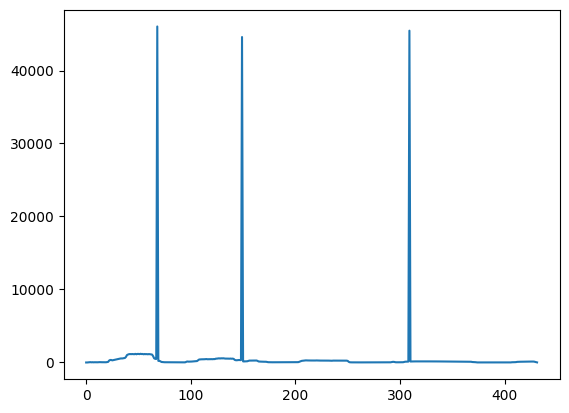

In [15]:
plt.plot(_center_pixel)

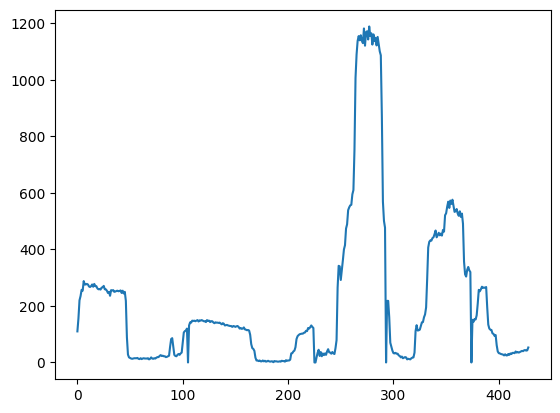

In [16]:
plt.plot(_center_pixel_skipped)

In [17]:
# sorted_images = _images
# g_angle2 = g_angle

In [18]:
g_angle2 = g_angle[sorted_inx]
_images = []


In [19]:
#define the filter function: Ram-Lak (R-L) filter and the Shepp-Logan(S-L) filter
#N:number of detector cells
#d: step width of detector cells
PI=math.pi

def filter_SL(N,d):
    fh_SL=np.zeros(N)
    for k1 in range(0,N,1):
        fh_SL[k1]=-2.0/(PI*PI*d*d*(4*(k1-N/2.0)**2-1))
    return fh_SL

def nearestPowerOf2(N):
    # Calculate log2 of N
    a = int(math.log2(N))
    if 2**a == N:
        return N
    return 2**(a + 1)

In [20]:
from scipy.fft import fft, ifft

def Fun_Weigth_Projection(projection_beta,SOD,delta_dd):
    Nrows,Ncolumns=projection_beta.shape
    dd_column=delta_dd*np.arange(-Ncolumns/2+0.5,(Ncolumns/2+1)-0.5,1.0)#coordinate of detector cell in horizontal 
    dd_row=delta_dd*np.arange(-Nrows/2+0.5,(Nrows/2+1)-0.5,1.0)#coordinate of detector cell in vertical
    dd_row2D,dd_column2D=np.meshgrid(dd_row,dd_column,indexing='ij')
    weighted_projection=projection_beta*SOD/np.sqrt(SOD*SOD+np.power(dd_row2D,2.0)+np.power(dd_column2D,2.0))
    return weighted_projection

def optimize_convolution(weighted_projection, fh_RL):
    Nrows, Ncolumns = weighted_projection.shape
    Nfft = nearestPowerOf2(2 * Ncolumns - 1)
    fh_RL_padded = np.zeros(Nfft)
    fh_RL_padded[:len(fh_RL)] = fh_RL / 2.0  # Scale and pad filter response
    
    fh_RL_fft = fft(fh_RL_padded)  # FFT of the filter response
    
    # Zero pad the input projection for FFT
    projection_padded = np.zeros((Nrows, Nfft))
    projection_padded[:, :Ncolumns] = weighted_projection

    # Perform FFT on each row of the projection
    projection_fft = fft(projection_padded, axis=1)
    
    # Element-wise multiplication in the frequency domain
    convoluted_freq = projection_fft * fh_RL_fft
    
    # Perform the inverse FFT to get back to the time domain
    convoluted_time = ifft(convoluted_freq, axis=1).real
    
    # Slice to obtain the result with the correct dimensions
    filtered_projection = convoluted_time[:, :Ncolumns]
    
    return filtered_projection


def Fun_Filter_Projection(weighted_projection,fh_RL):
    Nrows,Ncolumns=weighted_projection.shape
    Nfft=nearestPowerOf2(2*Ncolumns-1)
    filtered_projection=np.zeros((Nrows,Ncolumns))
    for row in range(Nrows):
        projection_row=weighted_projection[row,:]
        zeros_pad=np.zeros(Nfft-Ncolumns)
        projection_row=np.concatenate((projection_row,zeros_pad))
        convoluted_time=np.convolve(projection_row,fh_RL/2.0,mode='same')
        convoluted_time=convoluted_time[:Ncolumns]
        filtered_projection[row,:]=convoluted_time
    return filtered_projection

def Fun_BackProjection(filtered_projection,SOD,beta_num,beta_m,delta_dd,Nimage):
    Nrows,Ncolumns=filtered_projection.shape
    MX, MZ=Nimage,int(Nimage*Nrows/Ncolumns)
    #roi[0], roi[1]: the min and max of x-axis and y-axis
    #roi[2],roi[3]: the min and max of z-axis
    
    roi=delta_dd*np.array([-Ncolumns/2.0+0.5,Ncolumns/2.0-0.5,-Nrows/2.0+0.5,Nrows/2.0-0.5])
    hx=(roi[1]-roi[0])/(MX-1) #interval of x-axis and y-axis
    xrange=roi[0]+hx*np.arange(0,MX) #coordinate vector of x-axis and y-axis 
    hy=(roi[3]-roi[2])/(MZ-1) #interval of z-axis
    yrange=roi[2]+hy*np.arange(0,MZ) #coordinate vector of z-axis 
    XX,YY,ZZ=np.meshgrid(xrange,xrange,yrange,indexing='ij')
    temp_rec=np.zeros((MX,MX,MZ)) #store back projection contribution
    U=(SOD+XX*np.sin(beta_m)-YY*np.cos(beta_m))/SOD
    a=(XX*np.cos(beta_m)+YY*np.sin(beta_m))/U
    xx=np.int32(np.floor(a/delta_dd)) #beam numbering,strart from -Ncolumns/2
    u1=a/delta_dd-xx  #the decimal part of a
    b=ZZ/U
    yy=np.int32(np.floor(b/delta_dd)) #beam numbering,strart from -Nrows/2
    u2=b/delta_dd-yy #the decimal part of b
    xx=xx+int(Ncolumns/2) #numbering from 0
    yy=yy+int(Nrows/2) #numbering from 0

    mask=np.where((xx >=0) & (xx< Ncolumns-1) & (yy >=0) & (yy<Nrows-1))
    xx=xx[mask]
    yy=yy[mask]
    u1=u1[mask]
    u2=u2[mask]
    # print(mask)
    temp=(1-u1)*(1-u2)*filtered_projection[yy,xx]+(1-u1)*u2*filtered_projection[yy+1,xx]+\
                 (1-u2)*u1*filtered_projection[yy,xx+1]+u1*u2*filtered_projection[yy+1,xx+1]
    temp_rec[mask]=temp_rec[mask]+temp/(np.power(U[mask],2))*2*PI/beta_num
    print('backprojection, beta: ',round(beta_m*180/PI,1))
    return temp_rec


In [21]:
def ConeBeam_FDK_Backprojection(projection,fh_RL,beta,SOD,Nimage,delta_dd):
    # projection: projection data in 3D, (angle,row, colums)
    # fh_RL: R-L filter function
    # beta: rotate angles in degrees
    # SOD: source to rotation center distance in mm unit
    # delta_dd: interval of the virtual detector cell
    Ncolumns=projection.shape[2]
    Nrows=projection.shape[1]
    rec_image=np.zeros((Nimage,Nimage,int(Nimage*Nrows/Ncolumns)))
    beta_num=len(beta) #number of angles
    beta=beta*PI/180.0 # view angle in radian
    for m in range(0, beta_num,1):
        projection_beta=projection[m,:,:] #projection matrix at the beta angle
        weighted_projection=Fun_Weigth_Projection(projection_beta,SOD,delta_dd)
        filtered_projection=optimize_convolution(weighted_projection,fh_RL)
        rec_image=rec_image+Fun_BackProjection(weighted_projection,SOD,beta_num,beta[m],delta_dd,Nimage)
        # break
    return rec_image

In [22]:
sorted_images.shape

(429, 1190, 1190)

In [23]:
Ncolumns = sorted_images.shape[2]

In [24]:
SID = dcm.RTImageSID
SAD = dcm.RadiationMachineSAD

In [ ]:
Nimage=100 #size of image
beta=np.float32(g_angle2) #rotate(view) angles
SOD=SAD#source to origin distance, in unit mm
SDD=SID #source to center of detector, in unit mm
width=0.336 #size of detector cell, in unit mm
delta_dd=width*SOD/SDD #interval of the virtual detector cell
Nfft=nearestPowerOf2(2*Ncolumns-1) #number of points for FFT
fh_RL=filter_SL(Nfft,delta_dd)  #get the filter kernel function
print(np.repeat(1, fh_RL.shape[0]))
print(fh_RL.shape)
# asdf
# reconstruct the scanned object through the FBP algorithm
# rec_image=ConeBeam_FDK_Backprojection(sorted_images,fh_RL,beta,SOD,Nimage,delta_dd)
rec_image=ConeBeam_FDK_Backprojection(sorted_images,np.repeat(1, fh_RL.shape[0]),beta,SOD,Nimage,delta_dd)

[1 1 1 ... 1 1 1]
(4096,)
backprojection, beta:  0.1
backprojection, beta:  1.0
backprojection, beta:  1.9
backprojection, beta:  2.8
backprojection, beta:  3.7
backprojection, beta:  4.6
backprojection, beta:  5.4
backprojection, beta:  6.1
backprojection, beta:  6.9
backprojection, beta:  7.7
backprojection, beta:  8.4
backprojection, beta:  9.1
backprojection, beta:  9.9
backprojection, beta:  10.6
backprojection, beta:  11.4
backprojection, beta:  12.1
backprojection, beta:  12.9
backprojection, beta:  13.6
backprojection, beta:  14.4
backprojection, beta:  15.1
backprojection, beta:  15.9
backprojection, beta:  16.6
backprojection, beta:  17.4
backprojection, beta:  18.1
backprojection, beta:  18.9
backprojection, beta:  19.6
backprojection, beta:  20.4
backprojection, beta:  21.1
backprojection, beta:  21.9
backprojection, beta:  22.6
backprojection, beta:  23.3
backprojection, beta:  24.1
backprojection, beta:  24.8
backprojection, beta:  25.6
backprojection, beta:  26.3
backpro

In [26]:
rec_image = np.transpose(rec_image, (2, 1, 0))

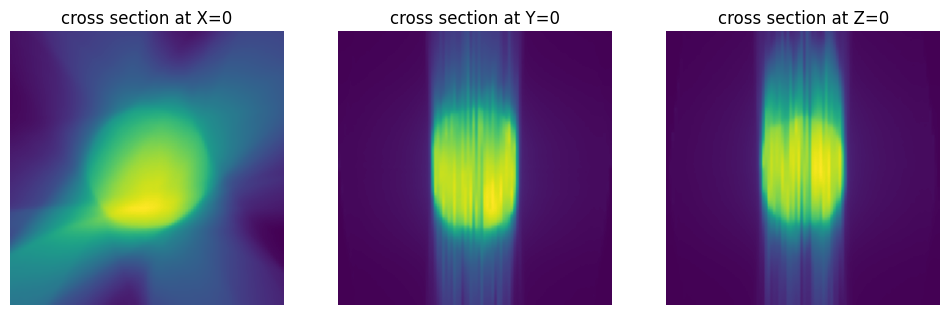

In [36]:
NimageZ=Nimage*sorted_images.shape[0]/sorted_images.shape[0]
Z_c=int(NimageZ/2.0)
X_c=int(Nimage/2.0)
Y_c=int(Nimage/2.0)
figure, axis=plt.subplots(1, 3,figsize=(12,12))
axis[0].imshow(rec_image[50,:,:].T, cmap='viridis')
axis[0].set_title('cross section at X=0')
axis[0].axis('off')
axis[1].imshow(rec_image[:,Y_c,:].T, cmap='viridis')
axis[1].set_title('cross section at Y=0')
axis[1].axis('off')
axis[2].imshow(rec_image[:,:,60].T, cmap='viridis')
axis[2].set_title('cross section at Z=0')
axis[2].axis('off')
# plt.savefig(directory+"rec_image.pdf",format='pdf',dpi=250)
plt.show()

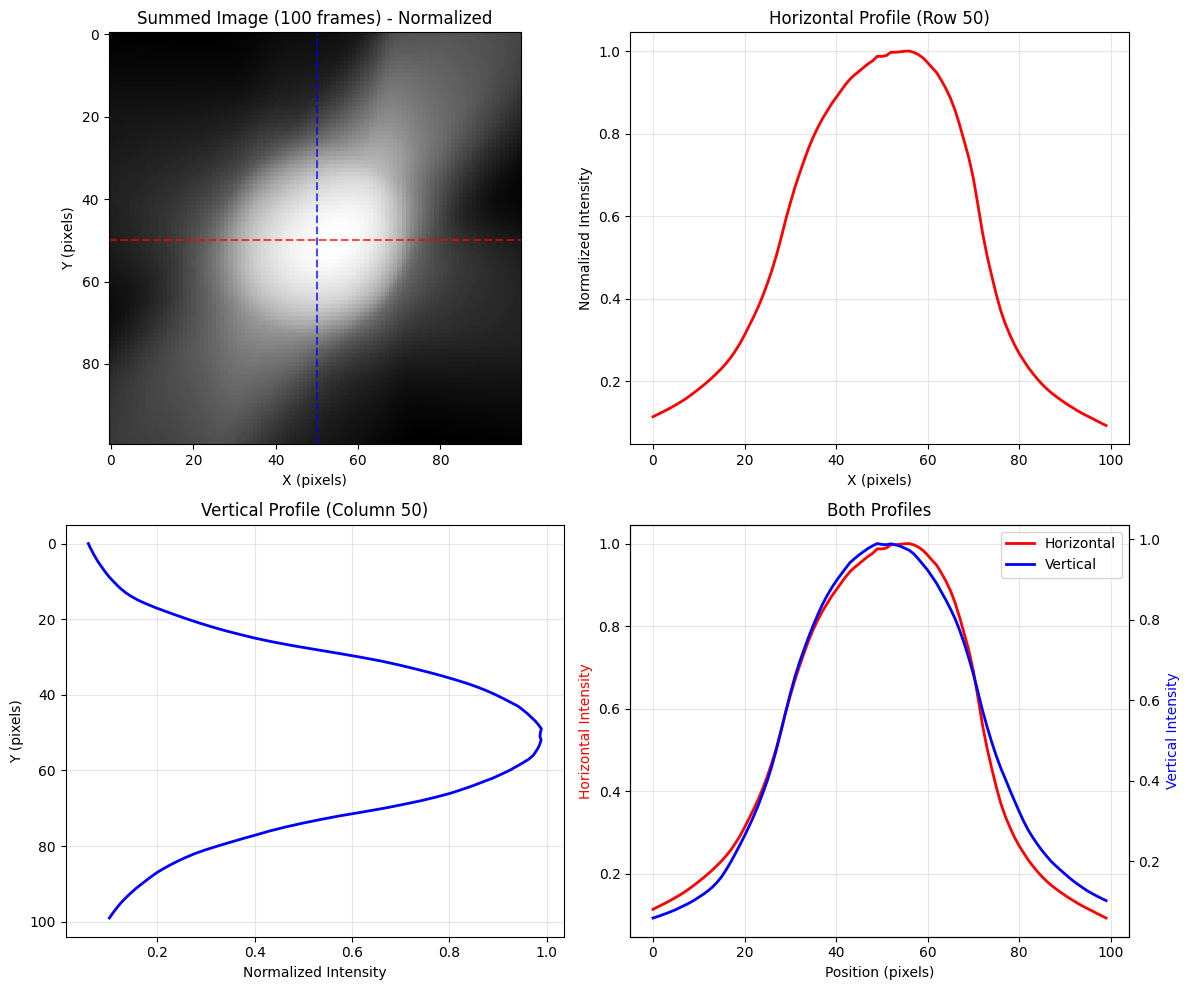

Original shape: (100, 100, 100)
Summed image range: 4665.34 to 50545.07
Normalized range: 0.000 to 1.000
Center coordinates: (50, 50)


In [28]:
# Sum all images along the first axis (F dimension)
summed_image = np.sum(rec_image, axis=0)

# Normalize the summed image to 0-1 range
normalized_summed = (summed_image - np.min(summed_image)) / (np.max(summed_image) - np.min(summed_image))

# Get image dimensions
height, width = normalized_summed.shape

# Calculate center coordinates
center_row = height // 2
center_col = width // 2

# Extract profiles at center
horizontal_profile = normalized_summed[center_row, :]  # Row at center
vertical_profile = normalized_summed[:, center_col]    # Column at center

# Plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Summed and normalized image with center lines
ax1.imshow(normalized_summed, cmap='gray')
ax1.axhline(y=center_row, color='red', linestyle='--', alpha=0.7)
ax1.axvline(x=center_col, color='blue', linestyle='--', alpha=0.7)
ax1.set_title(f'Summed Image ({rec_image.shape[0]} frames) - Normalized')
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')

# Horizontal profile
ax2.plot(horizontal_profile, 'r-', linewidth=2)
ax2.set_title(f'Horizontal Profile (Row {center_row})')
ax2.set_xlabel('X (pixels)')
ax2.set_ylabel('Normalized Intensity')
ax2.grid(True, alpha=0.3)

# Vertical profile
ax3.plot(vertical_profile, np.arange(height), 'b-', linewidth=2)
ax3.set_title(f'Vertical Profile (Column {center_col})')
ax3.set_xlabel('Normalized Intensity')
ax3.set_ylabel('Y (pixels)')
ax3.grid(True, alpha=0.3)
ax3.invert_yaxis()

# Both profiles together
ax4_twin = ax4.twinx()
ax4.plot(horizontal_profile, 'r-', linewidth=2, label='Horizontal')
ax4_twin.plot(vertical_profile, 'b-', linewidth=2, label='Vertical')
ax4.set_title('Both Profiles')
ax4.set_xlabel('Position (pixels)')
ax4.set_ylabel('Horizontal Intensity', color='red')
ax4_twin.set_ylabel('Vertical Intensity', color='blue')
ax4.grid(True, alpha=0.3)

# Add legends
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_twin.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

# Print some info
print(f"Original shape: {rec_image.shape}")
print(f"Summed image range: {np.min(summed_image):.2f} to {np.max(summed_image):.2f}")
print(f"Normalized range: {np.min(normalized_summed):.3f} to {np.max(normalized_summed):.3f}")
print(f"Center coordinates: ({center_col}, {center_row})")

In [30]:
tps_image.shape

(136, 109, 118)

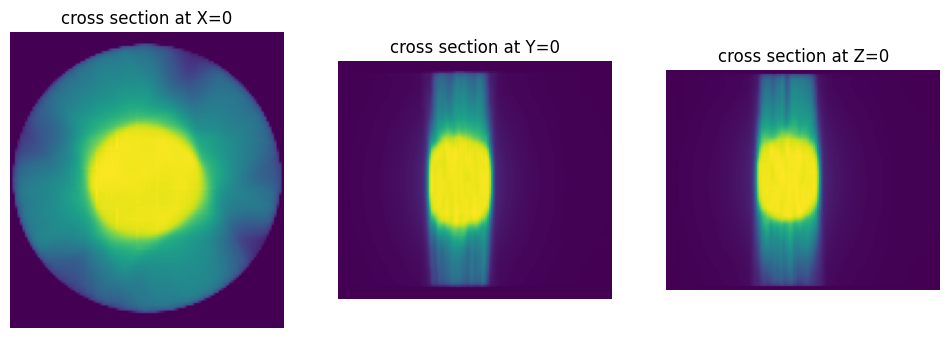

In [ ]:
_TPS_pth = r"E:\CMC\pyprojects\radio_therapy\dose-3d\dataset\VMAT 2025- TPS DOSE FILES\60Gy in 30#\3D DOSE\1. CENTRAL TARGET\RD.1.2.246.352.71.7.941004452793.3186027.20250604093515.dcm"

tps_dcm = dcmread(_TPS_pth)
tps_image = tps_dcm.pixel_array

tps_image.shape

NimageZ=Nimage*sorted_images.shape[0]/sorted_images.shape[0]
Z_c=int(NimageZ/2.0)
X_c=int(Nimage/2.0)
Y_c=int(Nimage/2.0)
figure, axis=plt.subplots(1, 3,figsize=(12,12))
axis[0].imshow(tps_image[60,:,:].T, cmap='viridis')
axis[0].set_title('cross section at X=0')
axis[0].axis('off')
axis[1].imshow(tps_image[:,Y_c,:].T, cmap='viridis')
axis[1].set_title('cross section at Y=0')
axis[1].axis('off')
axis[2].imshow(tps_image[:,:,Z_c].T, cmap='viridis')
axis[2].set_title('cross section at Z=0')
axis[2].axis('off')
# plt.savefig(directory+"rec_image.pdf",format='pdf',dpi=250)
plt.show()

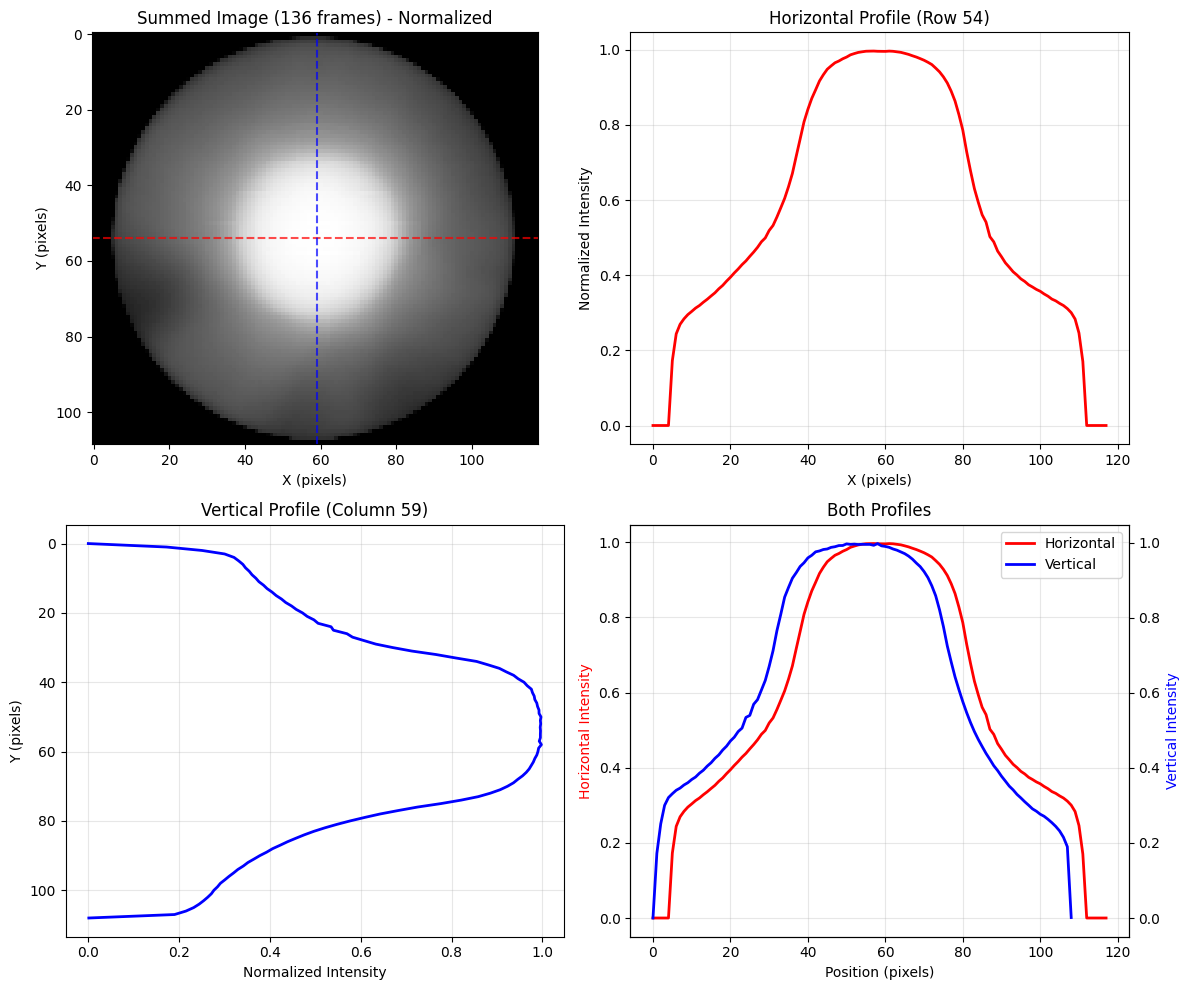

Original shape: (136, 109, 118)
Summed image range: 0.00 to 35996372.00
Normalized range: 0.000 to 1.000
Center coordinates: (59, 54)


In [32]:
# Sum all images along the first axis (F dimension)
summed_image = np.sum(tps_image, axis=0)

# Normalize the summed image to 0-1 range
normalized_summed = (summed_image - np.min(summed_image)) / (np.max(summed_image) - np.min(summed_image))

# Get image dimensions
height, width = normalized_summed.shape

# Calculate center coordinates
center_row = height // 2
center_col = width // 2

# Extract profiles at center
horizontal_profile = normalized_summed[center_row, :]  # Row at center
vertical_profile = normalized_summed[:, center_col]    # Column at center

# Plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Summed and normalized image with center lines
ax1.imshow(normalized_summed, cmap='gray')
ax1.axhline(y=center_row, color='red', linestyle='--', alpha=0.7)
ax1.axvline(x=center_col, color='blue', linestyle='--', alpha=0.7)
ax1.set_title(f'Summed Image ({tps_image.shape[0]} frames) - Normalized')
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')

# Horizontal profile
ax2.plot(horizontal_profile, 'r-', linewidth=2)
ax2.set_title(f'Horizontal Profile (Row {center_row})')
ax2.set_xlabel('X (pixels)')
ax2.set_ylabel('Normalized Intensity')
ax2.grid(True, alpha=0.3)

# Vertical profile
ax3.plot(vertical_profile, np.arange(height), 'b-', linewidth=2)
ax3.set_title(f'Vertical Profile (Column {center_col})')
ax3.set_xlabel('Normalized Intensity')
ax3.set_ylabel('Y (pixels)')
ax3.grid(True, alpha=0.3)
ax3.invert_yaxis()

# Both profiles together
ax4_twin = ax4.twinx()
ax4.plot(horizontal_profile, 'r-', linewidth=2, label='Horizontal')
ax4_twin.plot(vertical_profile, 'b-', linewidth=2, label='Vertical')
ax4.set_title('Both Profiles')
ax4.set_xlabel('Position (pixels)')
ax4.set_ylabel('Horizontal Intensity', color='red')
ax4_twin.set_ylabel('Vertical Intensity', color='blue')
ax4.grid(True, alpha=0.3)

# Add legends
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_twin.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

# Print some info
print(f"Original shape: {tps_image.shape}")
print(f"Summed image range: {np.min(summed_image):.2f} to {np.max(summed_image):.2f}")
print(f"Normalized range: {np.min(normalized_summed):.3f} to {np.max(normalized_summed):.3f}")
print(f"Center coordinates: ({center_col}, {center_row})")

TPS image shape: (136, 109, 118)
Rec image shape: (100, 100, 100)
TPS max value: 1060124.00
Rec max value: 1608.71
Normalization factor: 658.992
Normalized rec max: 1060124.00

Slice indices:
TPS slices - X: 50, Y: 54, Z: 59
Rec slices - X: 50, Y: 50, Z: 60


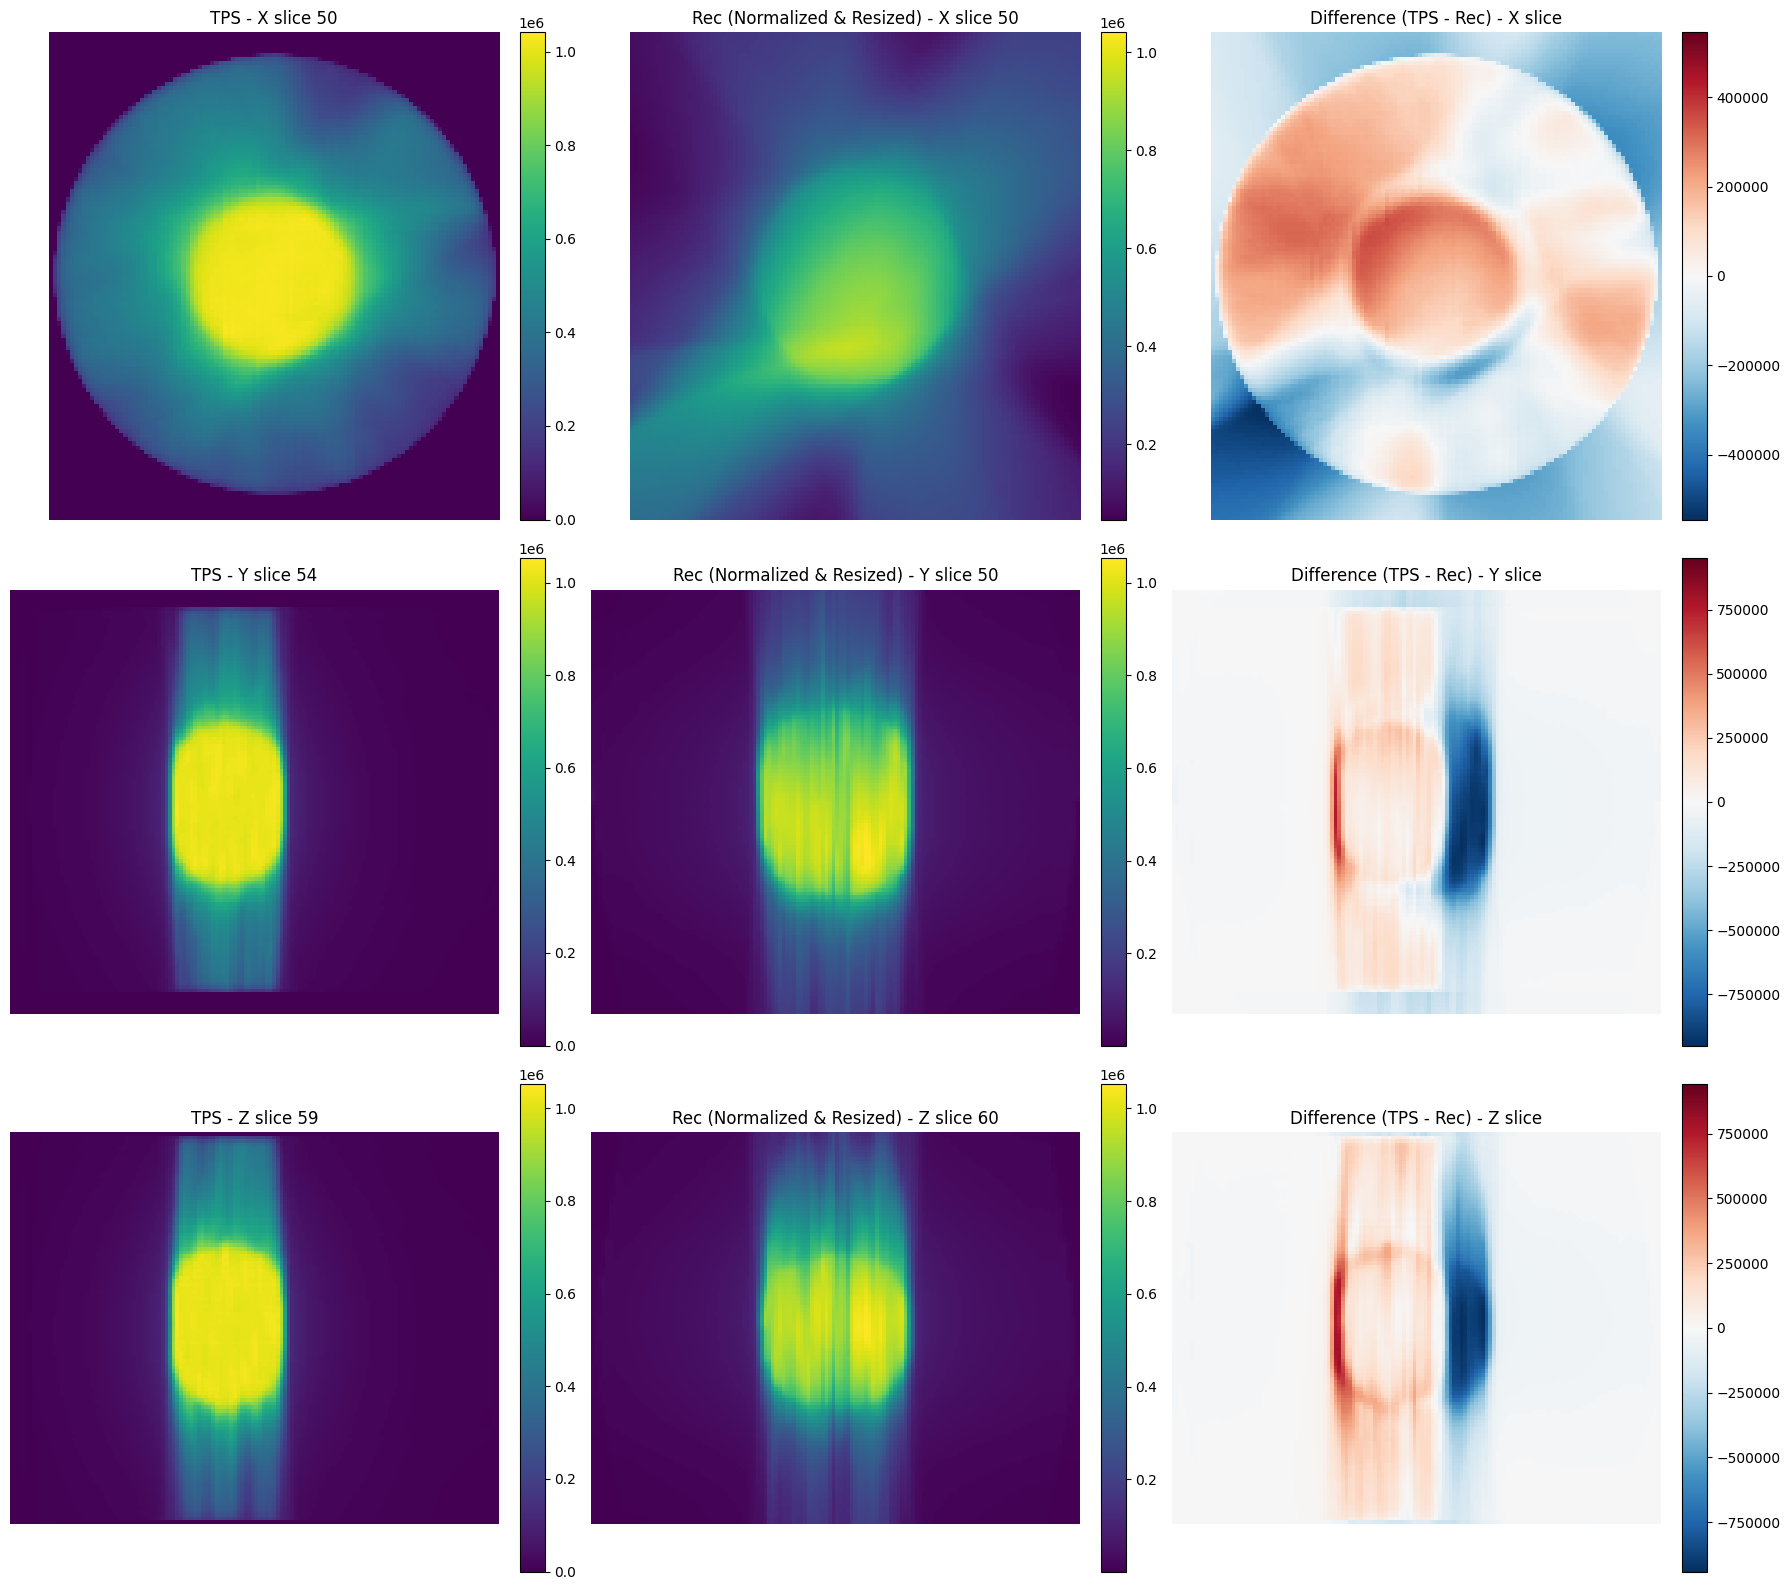


Difference Statistics:
X slice - Mean diff: -25063.838, Std: 194158.125, Range: [-545387.312, 360763.250]
Y slice - Mean diff: -36252.875, Std: 181928.297, Range: [-949882.062, 751337.562]
Z slice - Mean diff: -17626.004, Std: 190627.047, Range: [-940448.688, 797223.062]

Percentage Difference Statistics:
X slice - Mean: -70167954456576000.0%, Std: 125262515029409792.0%
Y slice - Mean: -6413230134001664.0%, Std: 31521323331092480.0%
Z slice - Mean: -1222610088099840.0%, Std: 11582249044541440.0%

Shape comparison after resizing:
X slices - TPS: (118, 109), Rec resized: (118, 109)
Y slices - TPS: (118, 136), Rec resized: (118, 136)
Z slices - TPS: (109, 136), Rec resized: (109, 136)


In [40]:
# Calculate normalization factor and handle data types
tps_max = np.max(tps_image).astype(np.float64)
rec_max = np.max(rec_image).astype(np.float64)
normalization_factor = tps_max / rec_max

# Normalize rec_image and ensure proper data type
rec_image_normalized = (rec_image.astype(np.float64) * normalization_factor).astype(np.float32)

print(f"TPS image shape: {tps_image.shape}")
print(f"Rec image shape: {rec_image.shape}")
print(f"TPS max value: {tps_max:.2f}")
print(f"Rec max value: {rec_max:.2f}")
print(f"Normalization factor: {normalization_factor:.3f}")
print(f"Normalized rec max: {np.max(rec_image_normalized):.2f}")

# Function to resize image to match target shape using interpolation
from scipy.ndimage import zoom

def resize_to_match(image, target_shape):
    """Resize image to match target shape using zoom interpolation"""
    zoom_factors = [target_shape[i] / image.shape[i] for i in range(len(target_shape))]
    return zoom(image, zoom_factors, order=1)

# Calculate centers for each image
Z_c_tps = int(tps_image.shape[0] / 2.0)
Y_c_tps = int(tps_image.shape[1] / 2.0)
X_c_tps = int(tps_image.shape[2] / 2.0)

Z_c_rec = int(rec_image.shape[0] / 2.0)
Y_c_rec = int(rec_image.shape[1] / 2.0)
X_c_rec = int(rec_image.shape[2] / 2.0)

# Define slice indices
x_slice_tps = min(50, tps_image.shape[0] - 1)
y_slice_tps = Y_c_tps
z_slice_tps = X_c_tps

x_slice_rec = min(50, rec_image.shape[0] - 1)
y_slice_rec = Y_c_rec
z_slice_rec = min(60, rec_image.shape[2] - 1)

print(f"\nSlice indices:")
print(f"TPS slices - X: {x_slice_tps}, Y: {y_slice_tps}, Z: {z_slice_tps}")
print(f"Rec slices - X: {x_slice_rec}, Y: {y_slice_rec}, Z: {z_slice_rec}")

# Extract slices and ensure float32 data type
tps_x_slice = tps_image[x_slice_tps, :, :].T.astype(np.float32)
rec_x_slice = rec_image_normalized[x_slice_rec, :, :].T.astype(np.float32)

tps_y_slice = tps_image[:, y_slice_tps, :].T.astype(np.float32)
rec_y_slice = rec_image_normalized[:, y_slice_rec, :].T.astype(np.float32)

tps_z_slice = tps_image[:, :, z_slice_tps].T.astype(np.float32)
rec_z_slice = rec_image_normalized[:, :, z_slice_rec].T.astype(np.float32)

# Resize rec slices to match TPS slices for subtraction
rec_x_slice_resized = resize_to_match(rec_x_slice, tps_x_slice.shape).astype(np.float32)
rec_y_slice_resized = resize_to_match(rec_y_slice, tps_y_slice.shape).astype(np.float32)
rec_z_slice_resized = resize_to_match(rec_z_slice, tps_z_slice.shape).astype(np.float32)

# Calculate differences with proper scaling
diff_x = tps_x_slice - rec_x_slice_resized
diff_y = tps_y_slice - rec_y_slice_resized
diff_z = tps_z_slice - rec_z_slice_resized

# Create comparison plot with 3 columns
fig, axes = plt.subplots(3, 3, figsize=(18, 16))

# X cross-sections with better difference scaling
vmax_x = max(np.max(tps_x_slice), np.max(rec_x_slice_resized))
diff_range_x = max(abs(np.min(diff_x)), abs(np.max(diff_x)))

im1 = axes[0, 0].imshow(tps_x_slice, cmap='viridis', vmax=vmax_x)
axes[0, 0].set_title(f'TPS - X slice {x_slice_tps}')
axes[0, 0].axis('off')

im2 = axes[0, 1].imshow(rec_x_slice_resized, cmap='viridis', vmax=vmax_x)
axes[0, 1].set_title(f'Rec (Normalized & Resized) - X slice {x_slice_rec}')
axes[0, 1].axis('off')

im3 = axes[0, 2].imshow(diff_x, cmap='RdBu_r', vmin=-diff_range_x, vmax=diff_range_x)
axes[0, 2].set_title(f'Difference (TPS - Rec) - X slice')
axes[0, 2].axis('off')

# Y cross-sections with better difference scaling
vmax_y = max(np.max(tps_y_slice), np.max(rec_y_slice_resized))
diff_range_y = max(abs(np.min(diff_y)), abs(np.max(diff_y)))

im4 = axes[1, 0].imshow(tps_y_slice, cmap='viridis', vmax=vmax_y)
axes[1, 0].set_title(f'TPS - Y slice {y_slice_tps}')
axes[1, 0].axis('off')

im5 = axes[1, 1].imshow(rec_y_slice_resized, cmap='viridis', vmax=vmax_y)
axes[1, 1].set_title(f'Rec (Normalized & Resized) - Y slice {y_slice_rec}')
axes[1, 1].axis('off')

im6 = axes[1, 2].imshow(diff_y, cmap='RdBu_r', vmin=-diff_range_y, vmax=diff_range_y)
axes[1, 2].set_title(f'Difference (TPS - Rec) - Y slice')
axes[1, 2].axis('off')

# Z cross-sections with better difference scaling
vmax_z = max(np.max(tps_z_slice), np.max(rec_z_slice_resized))
diff_range_z = max(abs(np.min(diff_z)), abs(np.max(diff_z)))

im7 = axes[2, 0].imshow(tps_z_slice, cmap='viridis', vmax=vmax_z)
axes[2, 0].set_title(f'TPS - Z slice {z_slice_tps}')
axes[2, 0].axis('off')

im8 = axes[2, 1].imshow(rec_z_slice_resized, cmap='viridis', vmax=vmax_z)
axes[2, 1].set_title(f'Rec (Normalized & Resized) - Z slice {z_slice_rec}')
axes[2, 1].axis('off')

im9 = axes[2, 2].imshow(diff_z, cmap='RdBu_r', vmin=-diff_range_z, vmax=diff_range_z)
axes[2, 2].set_title(f'Difference (TPS - Rec) - Z slice')
axes[2, 2].axis('off')

# Add colorbars
plt.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)
plt.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)
plt.colorbar(im3, ax=axes[0, 2], fraction=0.046, pad=0.04)
plt.colorbar(im4, ax=axes[1, 0], fraction=0.046, pad=0.04)
plt.colorbar(im5, ax=axes[1, 1], fraction=0.046, pad=0.04)
plt.colorbar(im6, ax=axes[1, 2], fraction=0.046, pad=0.04)
plt.colorbar(im7, ax=axes[2, 0], fraction=0.046, pad=0.04)
plt.colorbar(im8, ax=axes[2, 1], fraction=0.046, pad=0.04)
plt.colorbar(im9, ax=axes[2, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Calculate and print statistics
print(f"\nDifference Statistics:")
print(f"X slice - Mean diff: {np.mean(diff_x):.3f}, Std: {np.std(diff_x):.3f}, Range: [{np.min(diff_x):.3f}, {np.max(diff_x):.3f}]")
print(f"Y slice - Mean diff: {np.mean(diff_y):.3f}, Std: {np.std(diff_y):.3f}, Range: [{np.min(diff_y):.3f}, {np.max(diff_y):.3f}]")
print(f"Z slice - Mean diff: {np.mean(diff_z):.3f}, Std: {np.std(diff_z):.3f}, Range: [{np.min(diff_z):.3f}, {np.max(diff_z):.3f}]")

# Calculate percentage differences (avoid division by zero)
percent_diff_x = 100 * diff_x / (tps_x_slice + 1e-10)
percent_diff_y = 100 * diff_y / (tps_y_slice + 1e-10)
percent_diff_z = 100 * diff_z / (tps_z_slice + 1e-10)

print(f"\nPercentage Difference Statistics:")
print(f"X slice - Mean: {np.mean(percent_diff_x):.1f}%, Std: {np.std(percent_diff_x):.1f}%")
print(f"Y slice - Mean: {np.mean(percent_diff_y):.1f}%, Std: {np.std(percent_diff_y):.1f}%")
print(f"Z slice - Mean: {np.mean(percent_diff_z):.1f}%, Std: {np.std(percent_diff_z):.1f}%")

print(f"\nShape comparison after resizing:")
print(f"X slices - TPS: {tps_x_slice.shape}, Rec resized: {rec_x_slice_resized.shape}")
print(f"Y slices - TPS: {tps_y_slice.shape}, Rec resized: {rec_y_slice_resized.shape}")
print(f"Z slices - TPS: {tps_z_slice.shape}, Rec resized: {rec_z_slice_resized.shape}")

In [33]:
# Uncomment to save the reconstructed volume as DICOM
# try:
#     if 'tps_dcm' in locals():
        # Scale and prepare for DICOM export
scaled_image = np.int32(rec_image * 1)

# Create new DICOM based on TPS template
write_dicom = tps_dcm.copy()
write_dicom.NumberOfFrames = str(rec_image.shape[2])
write_dicom.Rows = rec_image.shape[0]
write_dicom.Columns = rec_image.shape[1]
write_dicom.PixelData = scaled_image.tobytes()

# Save with timestamp
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = f"E:\\CMC\\pyprojects\\radio_therapy\\dose-3d\\dataset\\3DDose\\EPID_CENTRAL_CENTRAL_SKIP_notranspose.dcm"
dcmwrite(output_path, write_dicom)
print(f"\nOptimized reconstruction saved to: {output_path}")
#     else:
#         print("TPS data not available - cannot save DICOM")
# except Exception as e:
#     print(f"Error saving DICOM: {e}")

# print("\nOptimized reconstruction complete!")


Optimized reconstruction saved to: E:\CMC\pyprojects\radio_therapy\dose-3d\dataset\3DDose\EPID_CENTRAL_CENTRAL_SKIP_notranspose.dcm


In [34]:
# _TPS_pth = r"C:\Users\Pintu\OneDrive - Christian Medical College\Fabricated Phantom Rotational RT\RT Dose and Plan\Rotational Arc_Fabricated Phantom CT plans\RD.23022024.3ARCs.dcm"

# tps_dcm = dcmread(_TPS_pth)
# tps_image = tps_dcm.pixel_array
